<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия." data-toc-modified-id="Линейная-регрессия.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия.</a></span></li><li><span><a href="#Ridge" data-toc-modified-id="Ridge-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Ridge</a></span></li><li><span><a href="#Lasso" data-toc-modified-id="Lasso-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Lasso</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

Таксомоторная компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
RS = 12345 # константа для random_state

In [2]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (LinearRegression, 
                                  Ridge, 
                                  Lasso)
from sklearn.metrics import (mean_absolute_error, 
                             mean_squared_error)
import warnings
from catboost import CatBoostRegressor
from sklearn.model_selection import (TimeSeriesSplit,  
                                     GridSearchCV)

In [3]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

Посмотрим на данные

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим, действительно ли данные расположены в хронологическом порядке.

In [6]:
data.info()
print('\nИндексы расположены в порядке возрастания' if data.index.is_monotonic_increasing else 
      'Индексы не расположены в поряядке возрастания')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB

Индексы расположены в порядке возрастания


Пропусков нет, тип данных соответствует их смыслу.  
Сделаем ресемплинг данных, чтобы получить количество заказов за каждый час.

In [7]:
data = data.resample('1H').sum()

Посмотрим на временной диапазон данных.

In [8]:
print(f'Первое наблюдение: {data.index.min()}')
print(f'Последнее наблюдение: {data.index.max()}')

Первое наблюдение: 2018-03-01 00:00:00
Последнее наблюдение: 2018-08-31 23:00:00


## Анализ

Посмотрим на скользящее среднее с размером окна 24 часа.

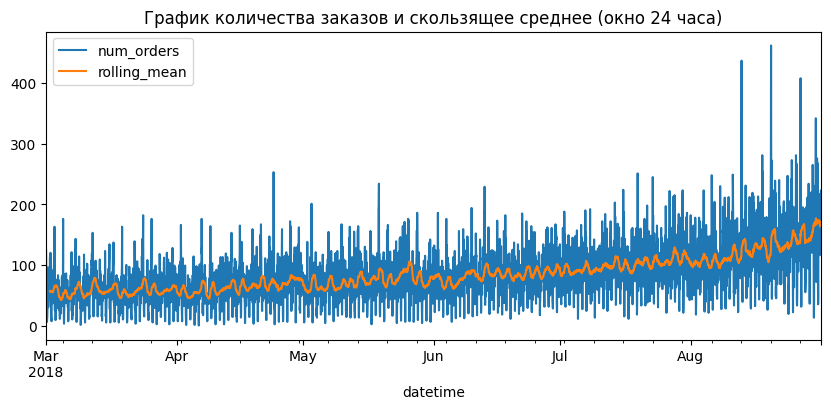

In [9]:
data['rolling_mean'] = data['num_orders'].rolling(24).mean()

data.plot(figsize = (10,4), title = 'График количества заказов и скользящее среднее (окно 24 часа)');

На графике видно наличие среднесуточных колебаний количества заказов, а также заметен тренд на увеличение количества заказов.

Рассмотрим тренд, сезонность и случайную составляющую в целевом признаке.

In [10]:
decomposed = seasonal_decompose(data['num_orders'])

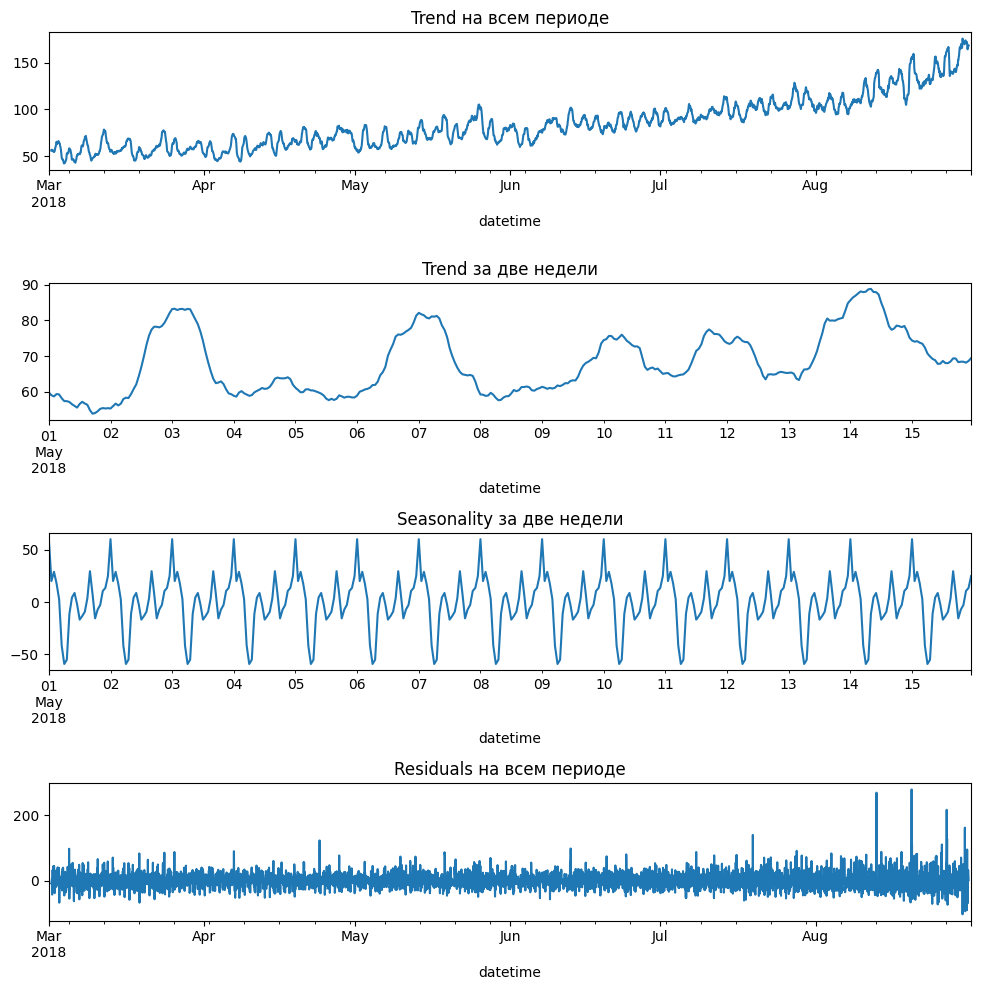

In [11]:
plt.figure(figsize=(10, 10))
plt.subplot(411)

decomposed.trend.plot()
plt.title('Trend на всем периоде') 
plt.subplot(412)
decomposed.trend['2018-05-01':'2018-05-15'].plot()
plt.title('Trend за две недели')
plt.subplot(413)
decomposed.seasonal['2018-05-01':'2018-05-15'].plot()
plt.title('Seasonality за две недели')
plt.subplot(414)
decomposed.resid.plot()
plt.title('Residuals на всем периоде')
plt.tight_layout()


Построим автокорреляционную функцию.


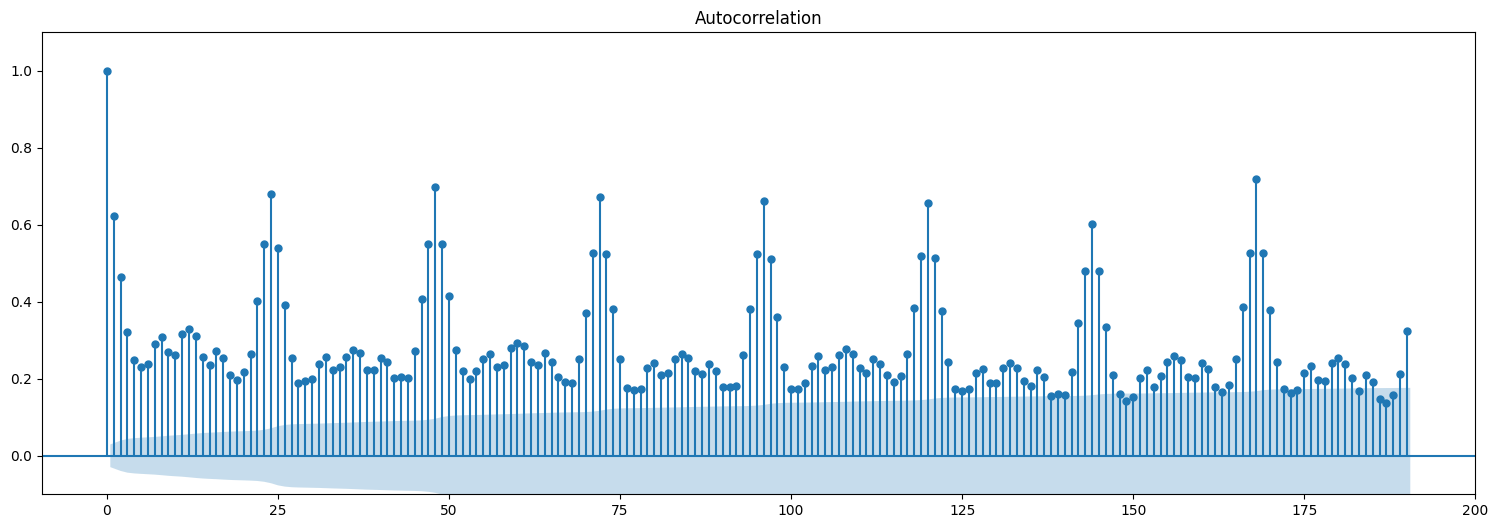

In [12]:
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(data['num_orders'],lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

На графиках виден восходящий тренд, его периодичность по неделям и суточная периодичность сезонности и автокорреляционной функции.

## Обучение

Поскольку мы работаем с временными рядими, и виден тренд на увеличение целевого признака, целесообразно применять линейные модели, потому что они обладают хорошей способностью экстраполировать предсказания. Экстраполирующие способности моделей на основе решающих деревьев ограничены. Также при работе с временными рядами нельзя использовать стандартную кросс-валидацию. Будем использовать TimeSeriesSplit. 

Подготовим данные. Возьмем информацию о времени, дне недели, суточное скользящее среднее и лаги за неделю.

In [ ]:
data = data[['num_orders']].copy()

data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

warnings.filterwarnings('ignore')
for lag in range(1, 168 + 1):
    data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
data['rolling_mean'] = data['num_orders'].shift().rolling(24).mean()
warnings.filterwarnings('default')
data = data.dropna()

data.shape

Разделим данные на обучающие и тестовые.

In [ ]:
train, test = train_test_split(data, test_size=0.1, shuffle=False)

features_train = train.drop(columns = ['num_orders'])
features_test = test.drop(columns = ['num_orders'])
target_train = train['num_orders']
target_test = test['num_orders']
    
features_train.shape, features_test.shape, target_train.shape, target_test.shape


In [ ]:
def params_search(model, X, y, param_grid):
    """
    Функция обучает модель и печатает лучшую метрику
    """
    tscv = TimeSeriesSplit(n_splits=10)
    gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_grid, scoring='neg_root_mean_squared_error', verbose=10)
    gsearch.fit(X, y)
    print('\nBest_score:', -gsearch.best_score_)
    print('Best_params:', gsearch.best_params_)
    return gsearch.best_estimator_

### Линейная регрессия.


In [ ]:
model_lr = LinearRegression()
params_lr = [{}]
model_lr = params_search(model_lr, features_train, target_train, params_lr)

### Ridge

 Подберем гиперпараметры для регресии Ridge.

In [ ]:
model_ridge = Ridge(random_state=RS)
params_ridge = [{'alpha' : np.arange(0, 5, 0.2), 'solver' : ['cholesky', 'sparse_cg', 'lbfgs'], 
                 'positive' : [True, False]}]
warnings.filterwarnings('ignore')
model_ridge = params_search(model_ridge, features_train, target_train, params_ridge)
warnings.filterwarnings('default')

### Lasso

 Подберем гиперпараметры для регресии Lasso.

In [ ]:
model_lasso = Ridge(random_state=RS)
params_lasso = [{'alpha' : np.arange(0, 5, 0.2), 'max_iter' : range(100, 3000, 100)}]
warnings.filterwarnings('ignore')
model_lasso = params_search(model_lasso, features_train, target_train, params_lasso)
warnings.filterwarnings('default')

### CatBoost

In [ ]:
model_cb = CatBoostRegressor(random_state=RS)
params_cb = [{'learning_rate' : np.arange(0.1, 0.6, 0.1), 'depth': [4, 6]}]
warnings.filterwarnings('ignore')
model_cb = params_search(model_cb, features_train, target_train, params_cb)
warnings.filterwarnings('default')

Лучший результат на валидации показала  регрессия CatBoost.

## Тестирование

Лучший результат на валидации показала  регрессия CatBoost. Однако она значительно более ресурсоемкая и долго обучается. Результаты линейных моделей отличаются незначительно, но они гораздо быстрее работают. Поэтому проверим на тестовой выборке модели CatBoost и Ridge. 

In [ ]:
# расчет RMSE CatBoost на тестовой выборке
pred = model_cb.predict(features_test)
print('RMSE CatBoost на тестовой выборке', mean_squared_error(target_test, pred)**0.5)

In [ ]:
# расчет RMSE Ridge на тестовой выборке
pred = model_ridge.predict(features_test)
print('RMSE Ridge на тестовой выборке', mean_squared_error(target_test, pred)**0.5)

Проверим модель на адекваьность. Сравним нашу модель с dummy-моделью, которая в качестве предсказания берет предыдущие значения.

In [ ]:
# получение предсказаний dummy-модели
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

# печать RMSE dummy-модели
print('RMSE Dummy на тестовой выборке', mean_squared_error(target_test, pred_previous)**0.5)

Разработанные модели адекватны.

## Выводы

В рамках проекта было проведено исследование данных по заказам такси в период с 01.03.2018 по 31.08.2018. Был обнаружен тренд на увеличение количества заказов, в связи с чем для прогнозирования использовались в основном линейные модели. В набор данных для прогнозирования были включены следующие параметры:
- час
- день недели
- значения целевого параметра за предыдущие 168 часов (одна неделя)
- скользящее среднее за предыдущие 24 часа.

Были созданы модели на основе линейной регрессии, Ridge, Lasso и CatBoost. Они показали близкие RMSE на валидационной выборке (21.9 - 22.52). В финальном тестировании участвовали две модели:  CatBoost и Ridge. При этом первая, показавшая лучший результат на валидации, на тесте показала результат хуже. Это может быть связано с особенностью данных, где тренд увеличения количества заказов усиливается в конце выборки (тестовая часть). Линейная модель продемонстрировала лучшую экстраполирующую способность.

Результаты тестирования:
- RMSE CatBoost: 37.75
- RMSE Ridge: 34.24